In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# reading all words
words = open('names.txt', 'r').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [3]:
# Let us check the total number of names
len(words)

32033

In [4]:
# Creating dictionaries to assign integer values to all the letters
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# Building the dataset with a function
block_size = 3
# A preferable block size for now

def build_dataset(words):
    X, Y = [], []

    for w in words:
        # initiating each word with 3 start/end characters prior to the first letter
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

# Dividing into train, validation, and test sets
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


# What exactly are we doing and why is it so cool?

## The goal
The goal here is to create a 2D space in which we put all the letters/chunks, which can then be trained to find a better arrangement which can reveal deeper patterns and correlations, which are later fed to the neural network.

## The process 
Here we take a block size of 3, which means that for every character, we check the 3 prior characters. This is implemented, by creating 2 tensors, X and Y

## X and Y
For each word in the words dataset, Y is appended a character, and X is appended the 3 characters prior to the character appended to Y. So effectively, X is a 2D tensor, where each row is a list of 3 numbers corresponding to the indices of the 3 characters which appear prior to a specific character in the tensor Y.

## What exactly is C?
C is a 2D matrix of 27 rows and 2 columns. Here, the 27 rows are made to represent the alphabet. The element corresponding to each alphabet has 2 elements within it. These numbers are randomly generated initially. 

## Putting it all together
we then create an 'Embedding vector', basically a new vector the same as the tensor X. The only difference being, each number in X is replaced with the number's corresponding character's corresponding 2-element list from C. Now, the reason why there's 2 numbers for each character in C is so that finally, in the embedding vector, we can get a 2D space where we can plot each chunk(embedding), and then after training, we get a spatial correlation of all the embeddings, resulting in a better dataset for the neural network.

In [23]:
# Initializing the weights
C = torch.randn((27, 10))

# Now we created the first layer, next we send the data to the second layer and introduce a non-linearity : tanh
W1 = torch.randn((30, 200))
b1 = torch.randn(200)

# Building the 2nd layer
W2 =  torch.randn((200,27))
b2 = torch.randn(27)

In [24]:
# Keeping count of all the parameters 
parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
# Adding a grad term to all parameters
for p in parameters:
    p.requires_grad = True

11897


In [25]:
# Keeping track of learning rate exponent
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [31]:
lri = []
lossi = []
stepi = []

for i in range(50000):

    # Use minibatches for more efficient energy usage
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # emb is the layer which maps everything in a vector space
    emb = C[Xtr[ix]]

    # Implementing the first layer along with the non-linearity
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)

    # Implementing the second layer
    logits = h @ W2 + b2

    # Loss function to implement backprop, Cross entropy is usually more efficient and handles edge cases well
    loss = F.cross_entropy(logits, Ytr[ix])

     # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # data update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    #stats
    stepi.append(i)
    lossi.append(loss.log10().item())

print(loss.item())

1.939353108406067


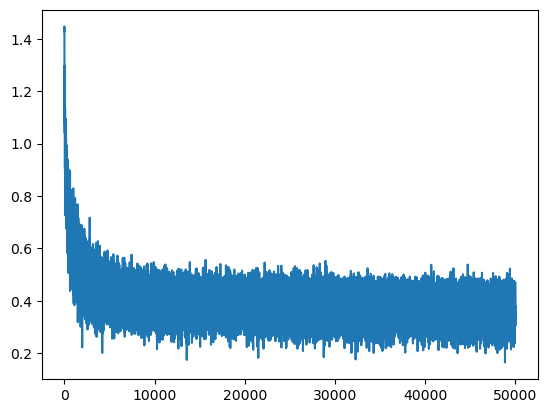

In [27]:
# Plotting the number of iterations against loss allows for better optimization, where we can decide when exactly to stop the algorithm
plt.plot(stepi, lossi)

Here, we can see the model optimizing as it hits around 5,000 iterations

In [ ]:
emb = C[Xtr] 
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) 
logits = h @ W2 + b2 
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.2385, grad_fn=<NllLossBackward0>)

In [ ]:
emb = C[Xdev] 
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) 
logits = h @ W2 + b2 
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.2721, grad_fn=<NllLossBackward0>)

We notice that the model does relatively well on the validation set (similar to the training set), which means it can be considered optimal

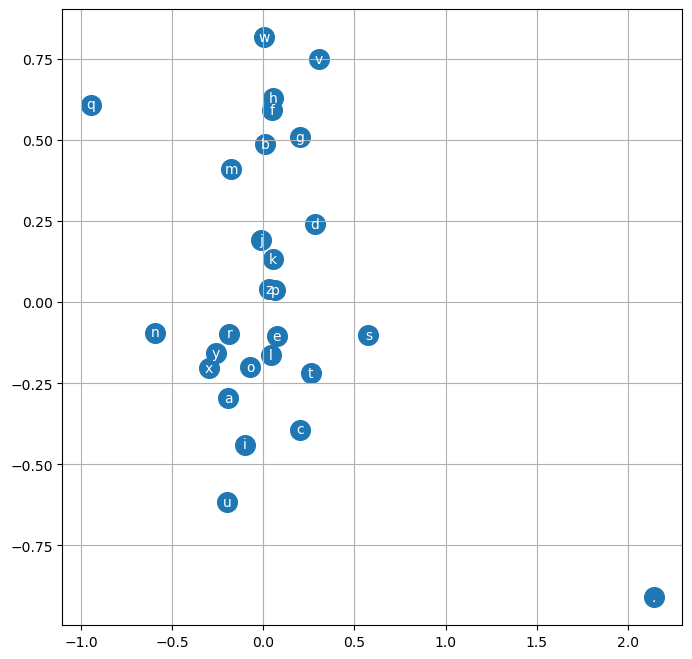

In [35]:
# visualizing dimensions 0 and 1 of the embedding matrix C for all characters, (2D representation for better intuition)
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [ ]:
emb = C[Xte] 
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) 
logits = h @ W2 + b2 
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.2795, grad_fn=<NllLossBackward0>)

The testing loss is on par with the development set, indicating a fairly accurate model

In [37]:
# Now we sample from the model and see what sort of names/words it generates
g = torch.Generator().manual_seed(2147483647 + 10) #For reproducibility

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

mora.
mayah.
heer.
nihaylee.
emma.
jendree.
caishedielin.
shyanelle.
elie.
camarielle.
malkia.
noshubur.
laimier.
janie.
jelipusteria.
uby.
gregriyah.
lyma.
huma.
mya.


The generated names do feel like actual names, looks like the vector space strategy worked!